Turns out the correspondence between cleaned ILI data spatial joined with pipeline segments, and the pipeline segments in EC_Risk_LOF table in Mariner isn't great.

Re-did the process by spatializing the `EC_Risk_LOF` as events in ArcMAP, and then spatial joining these events against the cleaned ILI data spatial-joined with pipeline segments. Hopefully there's better correspondence of the pipe segments.

In [1]:
# Plotting and math imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")

import pandas as pd

from datetime import datetime
from typing import List, Optional, Dict

# Load the spatially-joined, spatially-joined data saved in csv

In [2]:
ILI_2022_joined_pipeline_joins_EC_LOF_filename = r"C:\Users\A1YU\OneDrive - PGE\Documents\code\ModelPerformance\processed_data\cleaned_ILI_2022_joined_pipes_joins_EC_Risk_LOF_Events.csv"
master_dataset = pd.read_csv(ILI_2022_joined_pipeline_joins_EC_LOF_filename, low_memory=False)

In [3]:
master_dataset.columns.values

array(['OBJECTID_12', 'FID_1', 'OBJECTID_1', 'FID_1_1', 'Vendor',
       'Source', 'Route', 'Route_NoPr', 'MP1', 'MP2', 'Year',
       'ILI_Projec', 'ML_Survey', 'Alignment', 'Joint___US', 'ILI_Survey',
       'Joint_Leng', 'From_U_S_G', 'To_D_S_GW', 'Identifica', 'Comment',
       'Tool_Speed', 'WT__in_', 'SMYS__PSI_', 'MAOP__PSI_', 'OD__in_',
       'Longseam_V', 'Seam_Pos_', 'Depth____', 'Depth___wi', 'OD_Reducti',
       'Length__in', 'Width__in_', 'O_clock', 'Internal', 'Bend_Radiu',
       'Bend_Angle', 'Bend_Direc', 'POF_Catego', 'Associated',
       'Anomaly_ID', 'Estimated', 'Pf_MAOP', 'Pf___with', 'Pf__MAOP',
       'TotalBend', 'Bend___Ver', 'Bend___Hor', 'Internal_D',
       'External_D', 'Easting', 'Northing', 'Latitude', 'Longitude',
       'Elevation', 'U_S_Refere', 'Dist__To_U', 'D_S_Refere',
       'Dist__To_D', 'ILI_Vendor', 'PG_E_Stati', 'OBJECTID', 'Id',
       'EffectiveS', 'PipeManufa', 'PipeOutsid', 'PipeWallTh', 'SMYS',
       'PipeGradeD', 'PipeMateri', 'PipeRe

The field names gets screwed up/cut off during the spatial-join and writing to csv process (might need to do all this in ArcPy..). Let's rename them to actual names.

In [4]:
# First change the fields from ILI that we want
# FP_fields = ['Estimated Failure Pressure (Pf) ', 'Pf/MAOP', 'Pf* (with tool tolerances)', 'Pf*/MAOP']

master_dataset.rename(
    columns={
        "Estimated": "Estimated Failure Pressure (Pf)",
        "Pf_MAOP": "Pf/MAOP",
        "Pf___with": "Pf* (with tool tolerances)",
        "Pf__MAOP": "Pf*/MAOP",
    },
    inplace=True
)
FP_fields = ['Estimated Failure Pressure (Pf)', 'Pf/MAOP', 'Pf* (with tool tolerances)', 'Pf*/MAOP']

In [5]:
# Now change the EC_LOF_Risk values

calculated_risk_fields =  ['EC_LOF_Leak', 'EC_LOF_Rupture']
master_dataset.rename(
    columns={
        "EC_LOF_Rup": "EC_LOF_Rupture",
        "EC_LOF_Lea": "EC_LOF_Leak",
    },
    inplace=True
)

In [6]:
# Also get the stationing number, so we are not simply comparing individual anomaly to pipe values
location_fields = ["route", "beginstationseriesid", "beginstationnum", "endstationseriesid", "endstationnum"]
master_dataset.rename(
    columns={
        "Route": "route",
        "BeginStati": "beginstationseriesid",
        "BeginSta_1": "beginstationnum",
        "EndStation": "endstationseriesid",
        "EndStati_1": "endstationnum",
    },
    inplace=True
)

In [106]:
# Sanity check, total mileage for 2022's supposed to be 6500
unique_segments = master_dataset.drop_duplicates(subset=["beginstationseriesid", "beginstationnum", "endstationnum"])

In [118]:
np.sum((unique_segments["endstationnum"] - unique_segments["beginstationnum"]).to_numpy()) / 5280

401.56009090909095

In [7]:
# Get the data frame with just these fields
relevant_fields = FP_fields + calculated_risk_fields + location_fields
performance_df = master_dataset[relevant_fields]

In [8]:
performance_df.head()

,Estimated Failure Pressure (Pf),Pf/MAOP,Pf* (with tool tolerances),Pf*/MAOP,EC_LOF_Leak,EC_LOF_Rupture,route,beginstationseriesid,beginstationnum,endstationseriesid,endstationnum
0,0.0,0.00,0.0,0.00,9.166055e-08,0.0,DFM-1209-01,39887,29018.0,39887,29098.0
1,2346.0,3.61,2300.0,3.54,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5
2,0.0,0.00,0.0,0.00,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5
3,0.0,0.00,0.0,0.00,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5
4,0.0,0.00,0.0,0.00,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5


I think when all the failure pressure values are NULL, they get imported into ArcMAP as 0. So need to change them to `NaN`.

The risk values can actually be 0, judging by the mariner DB output.

In [9]:
master_dataset[FP_fields] = master_dataset[FP_fields].replace(0, np.nan)

In [10]:
performance_df.head()

,Estimated Failure Pressure (Pf),Pf/MAOP,Pf* (with tool tolerances),Pf*/MAOP,EC_LOF_Leak,EC_LOF_Rupture,route,beginstationseriesid,beginstationnum,endstationseriesid,endstationnum
0,0.0,0.00,0.0,0.00,9.166055e-08,0.0,DFM-1209-01,39887,29018.0,39887,29098.0
1,2346.0,3.61,2300.0,3.54,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5
2,0.0,0.00,0.0,0.00,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5
3,0.0,0.00,0.0,0.00,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5
4,0.0,0.00,0.0,0.00,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5


Not sure how to aggregate over the staioning yet... but let's plot all the non-NAN Pf numbers against the EC values.

In [11]:
filtered_df = performance_df[
    performance_df[FP_fields].notnull().all(1)
]

In [12]:
filtered_df.head()

,Estimated Failure Pressure (Pf),Pf/MAOP,Pf* (with tool tolerances),Pf*/MAOP,EC_LOF_Leak,EC_LOF_Rupture,route,beginstationseriesid,beginstationnum,endstationseriesid,endstationnum
0,0.0,0.00,0.0,0.00,9.166055e-08,0.0,DFM-1209-01,39887,29018.0,39887,29098.0
1,2346.0,3.61,2300.0,3.54,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5
2,0.0,0.00,0.0,0.00,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5
3,0.0,0.00,0.0,0.00,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5
4,0.0,0.00,0.0,0.00,9.166055e-08,0.0,DFM-1209-01,39887,39389.5,39887,39650.5


Text(0.5, 0.98, 'Failure pressure vs. Leak LOF')

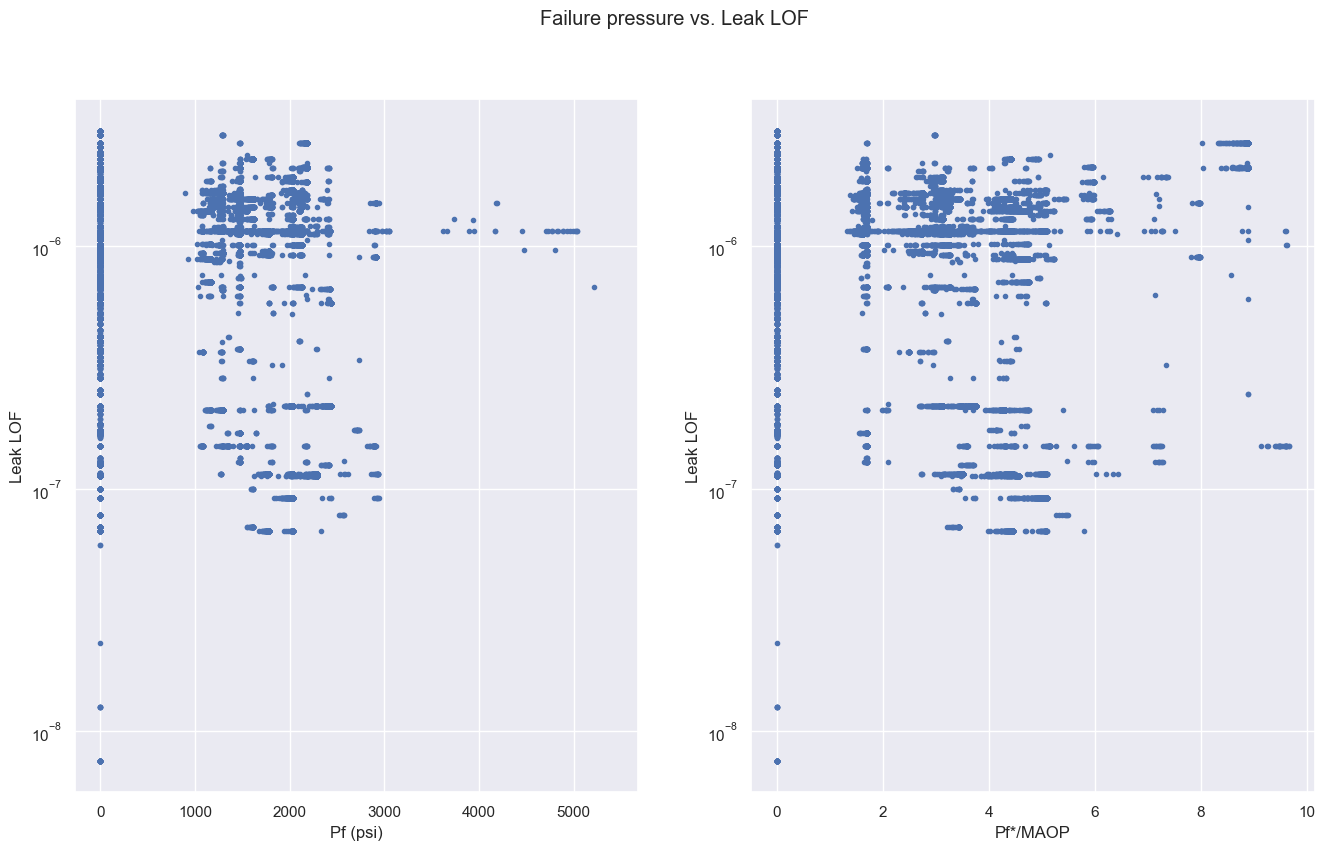

In [15]:
plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.plot(
    filtered_df["Estimated Failure Pressure (Pf)"],
    filtered_df["EC_LOF_Leak"],
    "."
)
plt.xlabel("Pf (psi)")
plt.ylabel("Leak LOF")
plt.yscale("log")

plt.subplot(1, 2, 2)
plt.plot(
    filtered_df["Pf*/MAOP"],
    filtered_df["EC_LOF_Leak"],
    "."
)
plt.xlabel("Pf*/MAOP")
plt.ylabel("Leak LOF")
plt.yscale("log")
plt.suptitle("Failure pressure vs. Leak LOF")

Text(0.5, 0.98, 'Failure pressure vs. Rupture LOF')

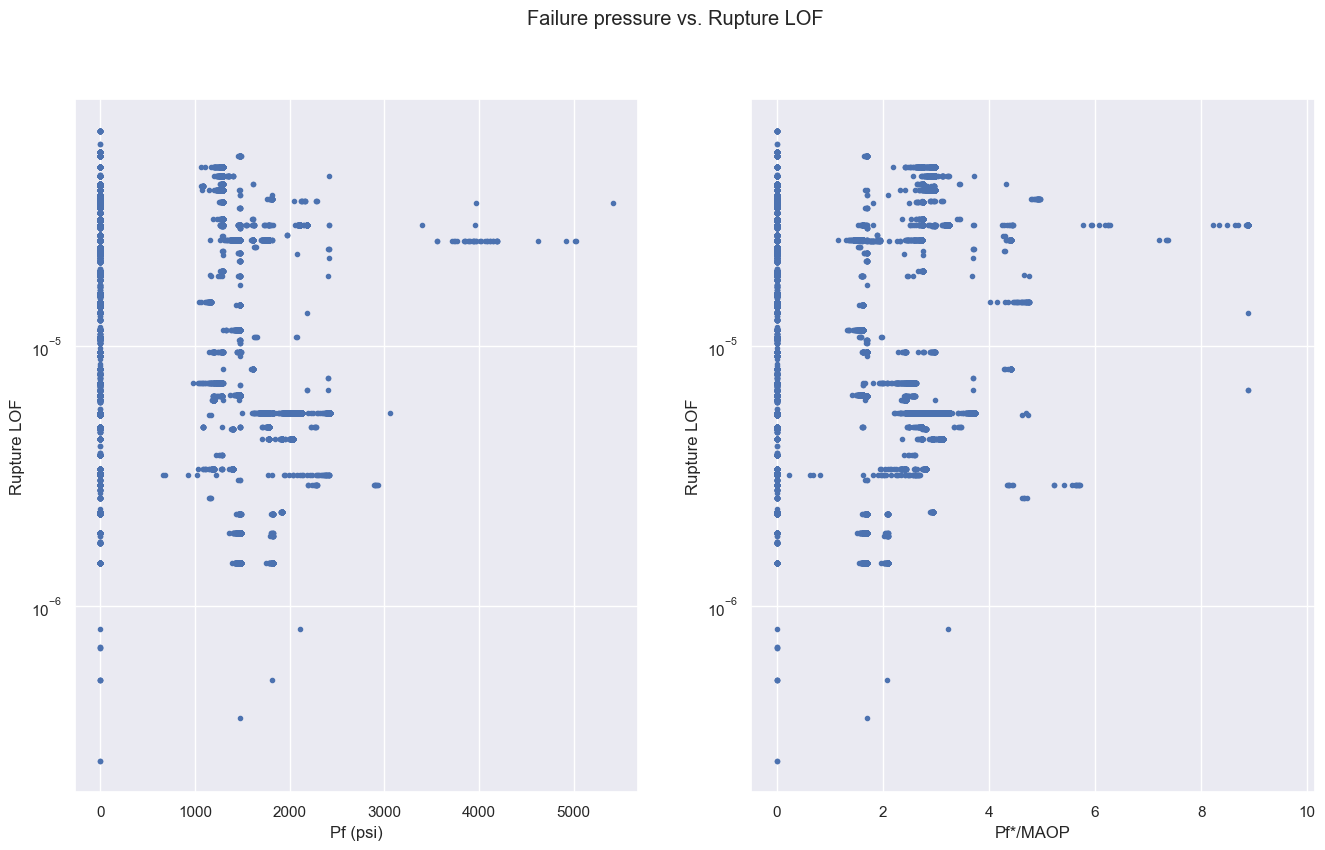

In [16]:
plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.plot(
    filtered_df["Estimated Failure Pressure (Pf)"],
    filtered_df["EC_LOF_Rupture"],
    "."
)
plt.xlabel("Pf (psi)")
plt.ylabel("Rupture LOF")
plt.yscale("log")

plt.subplot(1, 2, 2)
plt.plot(
    filtered_df["Pf*/MAOP"],
    filtered_df["EC_LOF_Rupture"],
    "."
)
plt.xlabel("Pf*/MAOP")
plt.ylabel("Rupture LOF")
plt.yscale("log")
plt.suptitle("Failure pressure vs. Rupture LOF")

## Aggregate anomalies' Pf per dynamic segment

Jackson says:

> In the EC_LOF table, each segments is defined by it's beginstationseriesid, it's beginstationnum and it's endstationnum so I'd aggregate on those three attributes

In [17]:
filtered_df.columns

Index(['Estimated Failure Pressure (Pf)', 'Pf/MAOP',
       'Pf* (with tool tolerances)', 'Pf*/MAOP', 'EC_LOF_Leak',
       'EC_LOF_Rupture', 'route', 'beginstationseriesid', 'beginstationnum',
       'endstationseriesid', 'endstationnum'],
      dtype='object')

In [20]:
# How many different `beginstationseriesid` are there?
len(np.unique(filtered_df["beginstationseriesid"]))

277

In [21]:
len(np.unique(filtered_df["endstationseriesid"]))

277

In [23]:
# Are begin and end stationseries id the same?
np.all(filtered_df["beginstationseriesid"] == filtered_df["endstationseriesid"])

True

Yes, so using `beginstationseriesid` should be enough.

In [25]:
stationing_vars = ["beginstationseriesid", "beginstationnum", "endstationnum"]
unique_segments =filtered_df[stationing_vars].drop_duplicates()

In [26]:
unique_segments

,beginstationseriesid,beginstationnum,endstationnum
0,39887,29018.0,29098.0
1,39887,39389.5,39650.5
7,39887,18313.8,18751.8
11,39887,33675.7,34126.1
12,39887,23847.9,24222.9
...,...,...,...
111423,37900,2241075.9,2241789.1
111443,37900,2108803.0,2108838.0
111646,47300,0.4,1.9
111648,46776,1.4,2.8


The ILI data maps to 9232 distinct pipeline segments. Are there the same number of unique risk values?

In [35]:
print(f"Number of unique EC_LOF_Leak values: {len(np.unique(filtered_df['EC_LOF_Leak']))}")
print(f"Number of unique EC_LOF_Rupture values: {len(np.unique(filtered_df['EC_LOF_Rupture']))}")

Number of unique EC_LOF_Leak values: 239
Number of unique EC_LOF_Rupture values: 144


So this means multiple pipe segments can still have the same risk values. But double check if the risk values for anomalies for each segment is the same -- they should be

In [46]:
np.sum(filtered_df.groupby(stationing_vars)["EC_LOF_Leak"].nunique() != 1)

2000

In [48]:
np.sum(filtered_df.groupby(stationing_vars)["EC_LOF_Rupture"].nunique() != 1)

1212

This is not the case...why? How come anomalies within the same dynamic segment aren't having the same calculated risk values?

In [49]:
result = filtered_df.groupby(stationing_vars)["EC_LOF_Leak"].nunique()
groups_with_varying_LOF_Leak = result[result != 1]

In [71]:
len(groups_with_varying_LOF_Leak) / len(result)

0.21663778162911612

In [74]:
np.unique(groups_with_varying_LOF_Leak, return_counts=True)

(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([1400,  383,  130,   44,   29,    4,    6,    2,    2], dtype=int64))

In [119]:
FP_fields

['Estimated Failure Pressure (Pf)',
 'Pf/MAOP',
 'Pf* (with tool tolerances)',
 'Pf*/MAOP']

In [120]:
stationing_vars

['beginstationseriesid', 'beginstationnum', 'endstationnum']

In [124]:
filtered_df.columns

Index(['Estimated Failure Pressure (Pf)', 'Pf/MAOP',
       'Pf* (with tool tolerances)', 'Pf*/MAOP', 'EC_LOF_Leak',
       'EC_LOF_Rupture', 'route', 'beginstationseriesid', 'beginstationnum',
       'endstationseriesid', 'endstationnum'],
      dtype='object')

In [125]:
from scipy import stats

diff_to_mode_perc = []

for (i, group) in enumerate(groups_with_varying_LOF_Leak.index):
    # if i > 2:
        # break?
    print(f"Group: {group}")
    group_rows = filtered_df[
        (filtered_df["beginstationseriesid"] == group[0])
        & (filtered_df["beginstationnum"] == group[1])
        & (filtered_df["endstationnum"] == group[2])
    ][["EC_LOF_Leak", "EC_LOF_Rupture"]] 
    print(group_rows)
    # What's the max diff?
    # max_diff = np.max(group_rows) - np.min(group_rows)
    # what percentage of the most common value?
    # mode_val = stats.mode(group_rows).mode
    # diff_to_mode_perc.append(max_diff / mode_val)
    # print(group_rows)
    # print(f"Max diff is {max_diff / mode_val * 100 :.3f}% of mode value")
    print("\n")

Group: (18421, 2585.05, 5858.0)
       EC_LOF_Leak  EC_LOF_Rupture
38719     0.000001             0.0
38720     0.000001             0.0
38721     0.000001             0.0
38722     0.000001             0.0
38723     0.000001             0.0
38724     0.000001             0.0
38725     0.000001             0.0
38726     0.000001             0.0
38754     0.000001             0.0
38755     0.000001             0.0
38756     0.000001             0.0
38757     0.000001             0.0
38762     0.000001             0.0
38763     0.000001             0.0
38764     0.000001             0.0
38765     0.000001             0.0
38766     0.000001             0.0
38767     0.000001             0.0
38768     0.000001             0.0
38769     0.000001             0.0
38770     0.000001             0.0
38771     0.000001             0.0
38772     0.000001             0.0
38773     0.000001             0.0
38774     0.000001             0.0
38777     0.000001             0.0
38796     0.000001     

In [95]:
np.unique(diff_to_mode_perc, return_counts=True)

(array([3.27322084e-03, 2.29382166e-02, 2.37481954e-02, 2.43258915e-02,
        3.94259938e-02, 4.13502544e-02, 4.19119343e-02, 4.99154732e-02,
        6.06654833e-02, 6.22603463e-02, 6.59937887e-02, 8.03006284e-02,
        8.06695714e-02, 8.26880936e-02, 8.34606103e-02, 8.38334365e-02,
        8.49952579e-02, 8.77481794e-02, 9.10605821e-02, 1.00191131e-01,
        1.03936654e-01, 1.04897179e-01, 1.06106254e-01, 1.06794101e-01,
        1.08901405e-01, 1.13048624e-01, 1.13545209e-01, 1.17190089e-01,
        1.21559968e-01, 1.22210275e-01, 1.23398693e-01, 1.25374148e-01,
        1.26495512e-01, 1.27457522e-01, 1.29200436e-01, 1.38209524e-01,
        1.38381635e-01, 1.42451091e-01, 1.46691173e-01, 1.46924935e-01,
        1.51564200e-01, 1.60374856e-01, 1.67379021e-01, 1.70186951e-01,
        1.70266217e-01, 1.70927980e-01, 1.71475441e-01, 1.71908655e-01,
        1.81016361e-01, 1.81046961e-01, 1.88201311e-01, 1.90100046e-01,
        1.90729301e-01, 2.06167831e-01, 2.06320280e-01, 2.063377

Are the difference in EC_LOF_Leak big enough to be significant? Why would a single pipe segment have different pipeline risk values?

This doesn't seem to make sense...each unique combination of `(beginstationseriesid, beginstationnum, endstationnum)` are supposed to represent a unique pipe segment, with a single EC_LOF value calculated.

But I'm seeing pipe "segments" aggregated this way can have up to 10 different risk values associated with them. Can this be accounted for spatial join errors? i.e. in a junction of pipe segments, multiple anomalies for different pipes get joined into the same?

Figure this out later...ask Gordon/Jackson. For now, just take the first value of these risk values...

In [28]:
FP_fields + calculated_risk_fields

['Estimated Failure Pressure (Pf)',
 'Pf/MAOP',
 'Pf* (with tool tolerances)',
 'Pf*/MAOP',
 'EC_LOF_Leak',
 'EC_LOF_Rupture']

Now we aggregate failure pressure from anomalies on pipe segments:
1. Mean
2. Min (less failure pressure = higher risk)

In [96]:
aggregation = {field: "mean" for field in FP_fields}
# Unclear if the risk values are different for segments because error or not...
aggregation.update({field: "first" for field in calculated_risk_fields})

filtered_df_grouped_by_mean = filtered_df.groupby(stationing_vars).agg(aggregation).reset_index()
filtered_df_grouped_by_min = filtered_df.groupby(stationing_vars).agg(aggregation).reset_index()

Text(0.5, 0.98, 'Failure pressure vs. Leak LOF, aggregate by pipe segment')

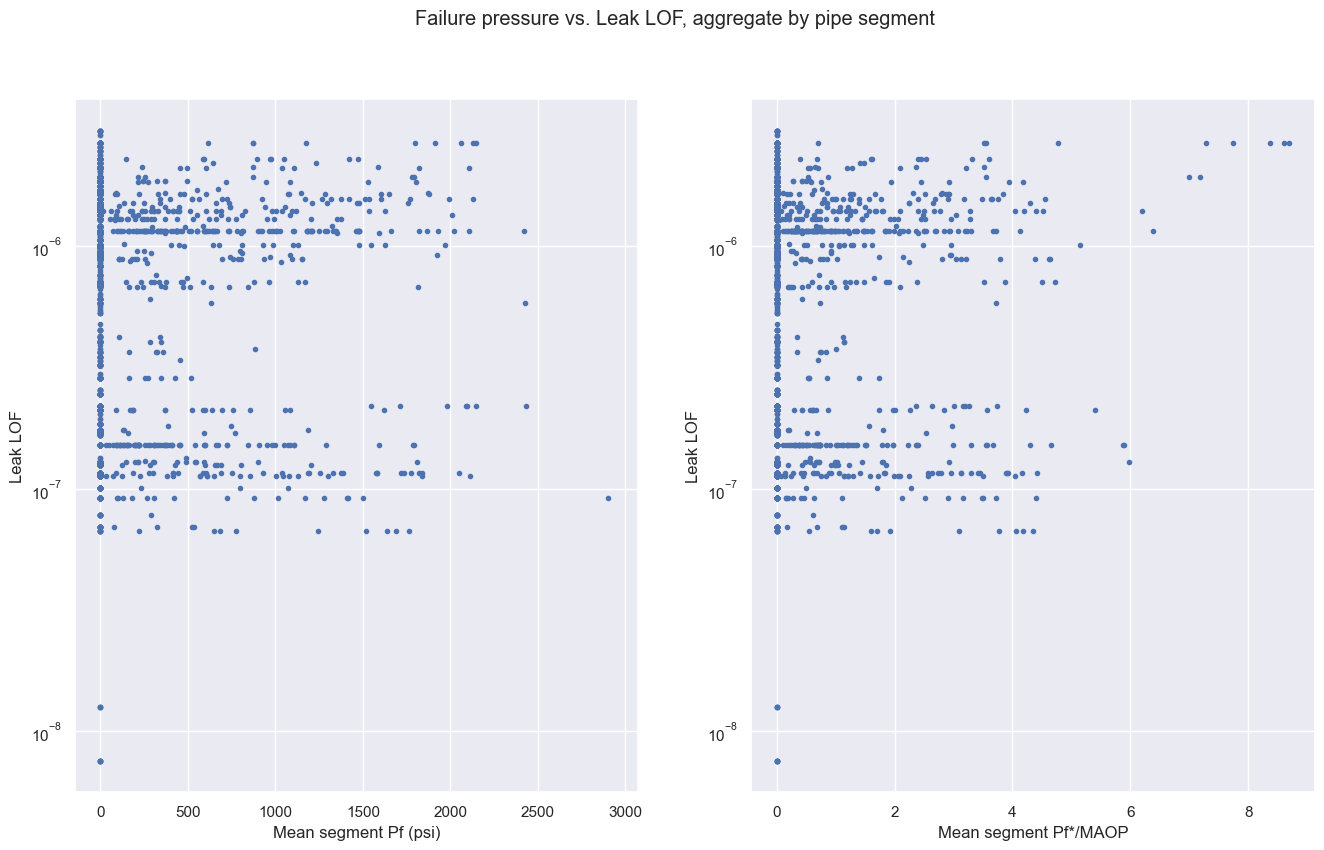

In [99]:
plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.plot(
    filtered_df_grouped_by_mean["Estimated Failure Pressure (Pf)"],
    filtered_df_grouped_by_mean["EC_LOF_Leak"],
    "."
)
plt.xlabel("Mean segment Pf (psi)")
plt.ylabel("Leak LOF")
plt.yscale("log")

plt.subplot(1, 2, 2)
plt.plot(
    filtered_df_grouped_by_mean["Pf*/MAOP"],
    filtered_df_grouped_by_mean["EC_LOF_Leak"],
    "."
)
plt.xlabel("Mean segment Pf*/MAOP")
plt.ylabel("Leak LOF")
plt.yscale("log")
plt.suptitle("Failure pressure vs. Leak LOF, aggregate by pipe segment")

Text(0.5, 0.98, 'Failure pressure vs. Rupture LOF')

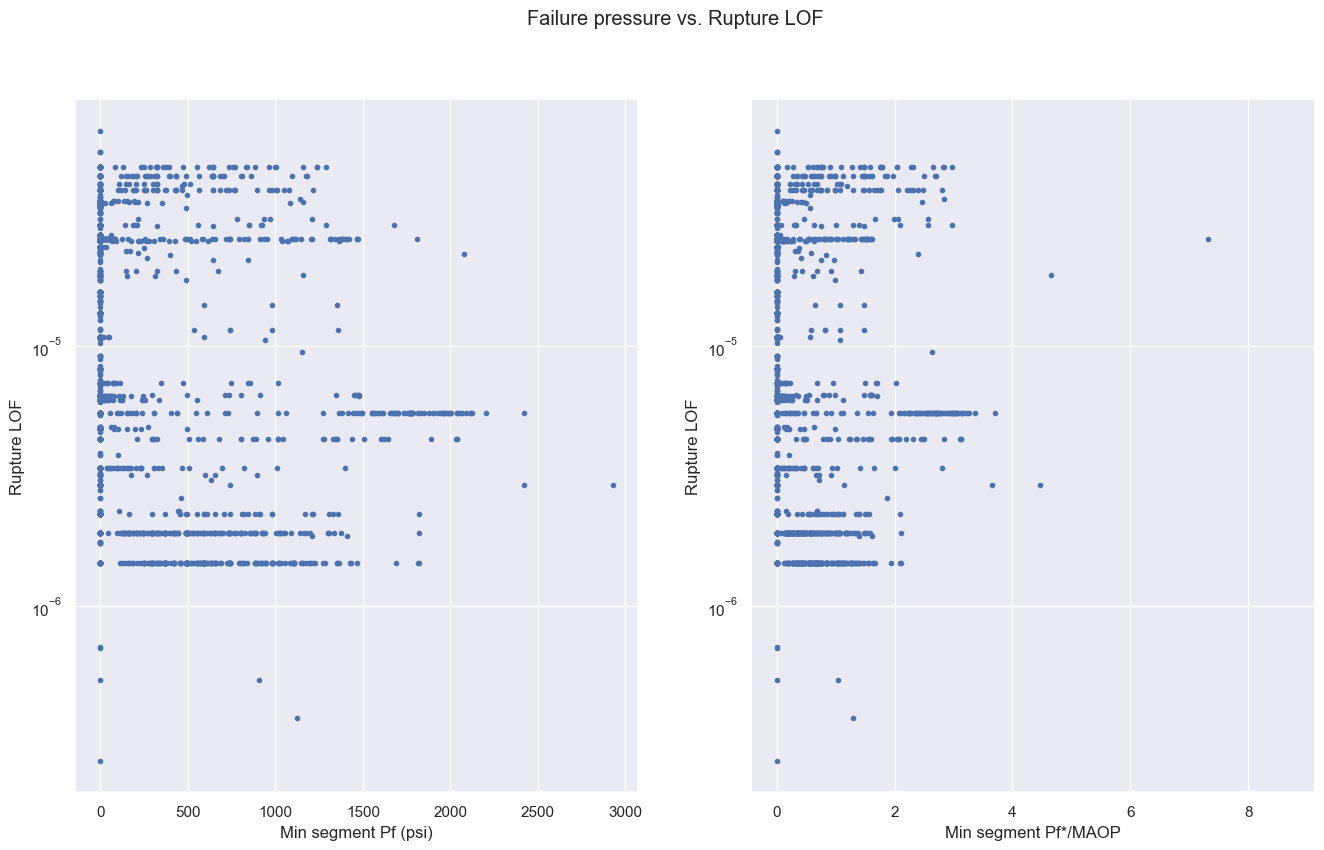

In [100]:
plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.plot(
    filtered_df_grouped_by_min["Estimated Failure Pressure (Pf)"],
    filtered_df_grouped_by_min["EC_LOF_Rupture"],
    "."
)
plt.xlabel("Min segment Pf (psi)")
plt.ylabel("Rupture LOF")
plt.yscale("log")

plt.subplot(1, 2, 2)
plt.plot(
    filtered_df_grouped_by_min["Pf*/MAOP"],
    filtered_df_grouped_by_min["EC_LOF_Rupture"],
    "."
)
plt.xlabel("Min segment Pf*/MAOP")
plt.ylabel("Rupture LOF")
plt.yscale("log")
plt.suptitle("Failure pressure vs. Rupture LOF")

For both, once aggregated by pipe segment, doesn't seem like there's any relationship between failure pressure and risk LOF...

In [ ]:
# Try to replicate this for LOF vs. Corrosion percentage
# Maybe also flaw size..?